In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import resample
from scipy import stats

In [5]:
path_chest = "/kaggle/input/dataset-chest/combined_chest_filtered.pkl"

In [6]:
path_wrist = "/kaggle/input/dataset-wrist-filt/combined_wrist_filtered.pkl"

In [7]:
df_chest = pd.read_pickle(path_chest)

In [8]:
df_wrist = pd.read_pickle(path_wrist)

In [9]:
df_chest.head()

,id,ACC_x,ACC_y,ACC_z,ECG,EMG,EDA,TEMP,RESP,label
214583,2.0,0.8914,-0.1102,-0.2576,0.030945,-0.003708,5.710983,29.083618,1.191711,1.0
214584,2.0,0.8926,-0.1086,-0.2544,0.033646,-0.014145,5.719376,29.122437,1.139832,1.0
214585,2.0,0.8930,-0.1094,-0.2580,0.033005,0.010208,5.706406,29.115234,1.141357,1.0
214586,2.0,0.8934,-0.1082,-0.2538,0.031815,0.012634,5.712509,29.126709,1.155090,1.0
214587,2.0,0.8930,-0.1096,-0.2570,0.030350,0.002060,5.727005,29.100861,1.133728,1.0


In [9]:
df_chest.dtypes

id       float64
ACC_x    float64
ACC_y    float64
ACC_z    float64
ECG      float64
EMG      float64
EDA      float64
TEMP     float64
RESP     float64
label    float64
dtype: object

In [7]:
df_chest.isnull().sum()

id       0
ACC_x    0
ACC_y    0
ACC_z    0
ECG      0
EMG      0
EDA      0
TEMP     0
RESP     0
label    0
dtype: int64

In [8]:
df_chest.isna().any()

id       False
ACC_x    False
ACC_y    False
ACC_z    False
ECG      False
EMG      False
EDA      False
TEMP     False
RESP     False
label    False
dtype: bool

In [10]:
df_wrist.head()

,id,ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,label
214583,2.0,39.469502,27.912214,29.039982,-109.222518,1.637703,35.809887,1.0
214584,2.0,38.595181,27.796006,29.093324,-108.599068,1.637493,35.809884,1.0
214585,2.0,37.719606,27.683257,29.114913,-107.981064,1.637285,35.809882,1.0
214586,2.0,36.849917,27.575278,29.103982,-107.368689,1.637080,35.809879,1.0
214587,2.0,35.993018,27.473250,29.060322,-106.762018,1.636878,35.809876,1.0


In [11]:
df_wrist.dtypes

id       float64
ACC_x    float64
ACC_y    float64
ACC_z    float64
BVP      float64
EDA      float64
TEMP     float64
label    float64
dtype: object

In [12]:
df_wrist.isnull().sum()

id       0
ACC_x    0
ACC_y    0
ACC_z    0
BVP      0
EDA      0
TEMP     0
label    0
dtype: int64

In [13]:
df_wrist.isna().any()

id       False
ACC_x    False
ACC_y    False
ACC_z    False
BVP      False
EDA      False
TEMP     False
label    False
dtype: bool

# Datos recopilados de pecho de los 15 participantes

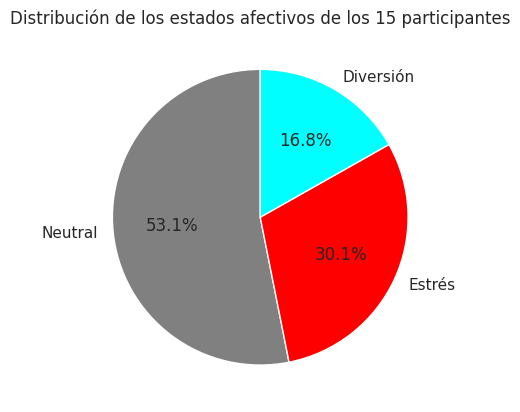

In [23]:
df_chest.loc[:, 'label']  = df_chest['label'].replace({1: 'Neutral', 2: 'Estrés', 3: 'Diversión'})
percentage_counts = df_chest["label"].value_counts(normalize=True) * 100
colors = ('gray', 'red', 'cyan')
plt.pie(percentage_counts, labels=percentage_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribución de los estados afectivos de los 15 participantes')
plt.show()

In [20]:
# mostrar la correlación entre las variables númericas
df_num = df_chest.drop(['id', 'label'], axis=1)
corr_chest = df_num.corr()
corr_chest.style.background_gradient(cmap='coolwarm')

,ACC_x,ACC_y,ACC_z,ECG,EMG,EDA,TEMP,RESP
ACC_x,1.000000,0.192109,0.831790,-0.001785,0.012507,0.034750,0.243962,-0.002141
ACC_y,0.192109,1.000000,0.196999,0.000351,-0.012374,0.105160,0.258578,-0.004738
ACC_z,0.831790,0.196999,1.000000,-0.001182,0.011261,-0.003949,0.199546,0.001675
ECG,-0.001785,0.000351,-0.001182,1.000000,-0.135529,-0.000220,0.000277,0.007168
EMG,0.012507,-0.012374,0.011261,-0.135529,1.000000,-0.001133,-0.003599,-0.000052
EDA,0.034750,0.105160,-0.003949,-0.000220,-0.001133,1.000000,0.184643,-0.000575
TEMP,0.243962,0.258578,0.199546,0.000277,-0.003599,0.184643,1.000000,0.000605
RESP,-0.002141,-0.004738,0.001675,0.007168,-0.000052,-0.000575,0.000605,1.000000


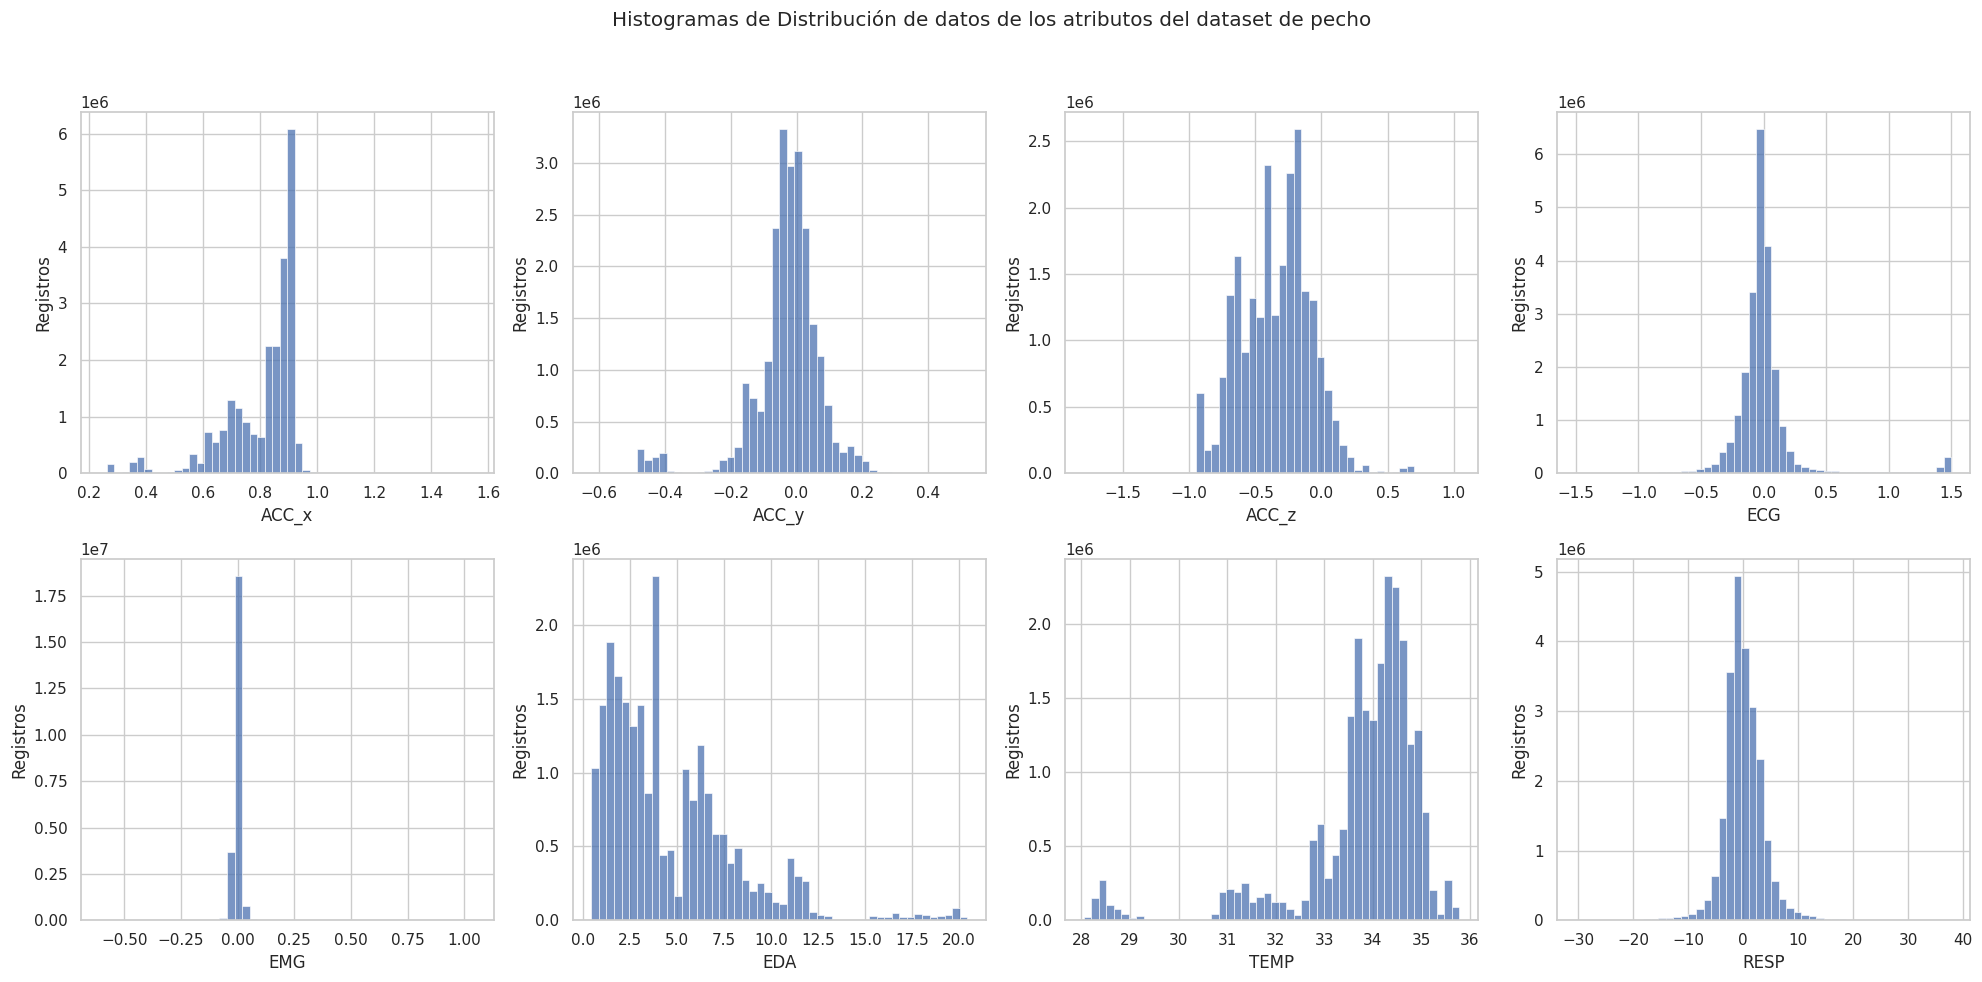

In [21]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Histogramas de Distribución de datos de los atributos del dataset de pecho')

for i, column in enumerate(df_num.columns):
    sns.histplot(df_num[column], bins=50, kde=False, ax=axes[i//4, i%4])
    #axes[i//4, i%4].set_title(column)
    axes[i//4, i%4].set_ylabel('Registros') 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

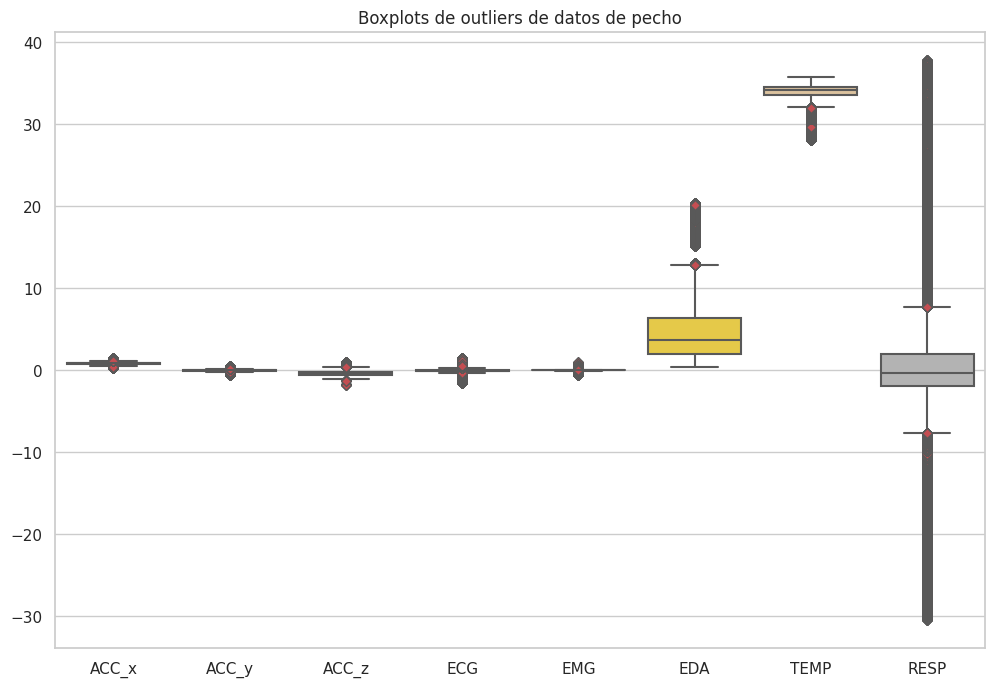

In [24]:
# comprobar outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_num, palette='Set2', orient='v', flierprops=dict(markerfacecolor='r', marker='D'))

plt.title('Boxplots de outliers de datos de pecho')

plt.show()

In [25]:
z_scores = np.abs((df_num - df_num.mean()) / df_num.std())
threshold = 3 
outliers_count = (z_scores > threshold).sum()
print("Cantidad de outliers en cada columna:\n", outliers_count)

Cantidad de outliers en cada columna:
 ACC_x    778874
ACC_y    783518
ACC_z    107838
ECG      656941
EMG      335816
EDA      448000
TEMP     720167
RESP     412212
dtype: int64


In [39]:
n_registers = df_chest.count()[0]
percentage = 783518/n_registers
print(f'El mayor porcentaje de outliers en el conjunto de datos es {percentage * 100:.2f}%')

El mayor porcentaje de outliers en el conjunto de datos es 3.38%


# Datos recopilados de muñeca de los 15 participantes

In [43]:
# mostrar la correlación entre las variables númericas
df_num = df_wrist.drop(['id', 'label'], axis=1)
corr_wrist = df_num.corr()
corr_wrist.style.background_gradient(cmap='coolwarm')

,ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP
ACC_x,1.000000,-0.039538,0.173682,0.000197,0.183063,0.097368
ACC_y,-0.039538,1.000000,0.101976,0.001150,-0.144961,0.061493
ACC_z,0.173682,0.101976,1.000000,-0.000317,0.019568,-0.100631
BVP,0.000197,0.001150,-0.000317,1.000000,0.000259,-0.000027
EDA,0.183063,-0.144961,0.019568,0.000259,1.000000,0.178714
TEMP,0.097368,0.061493,-0.100631,-0.000027,0.178714,1.000000


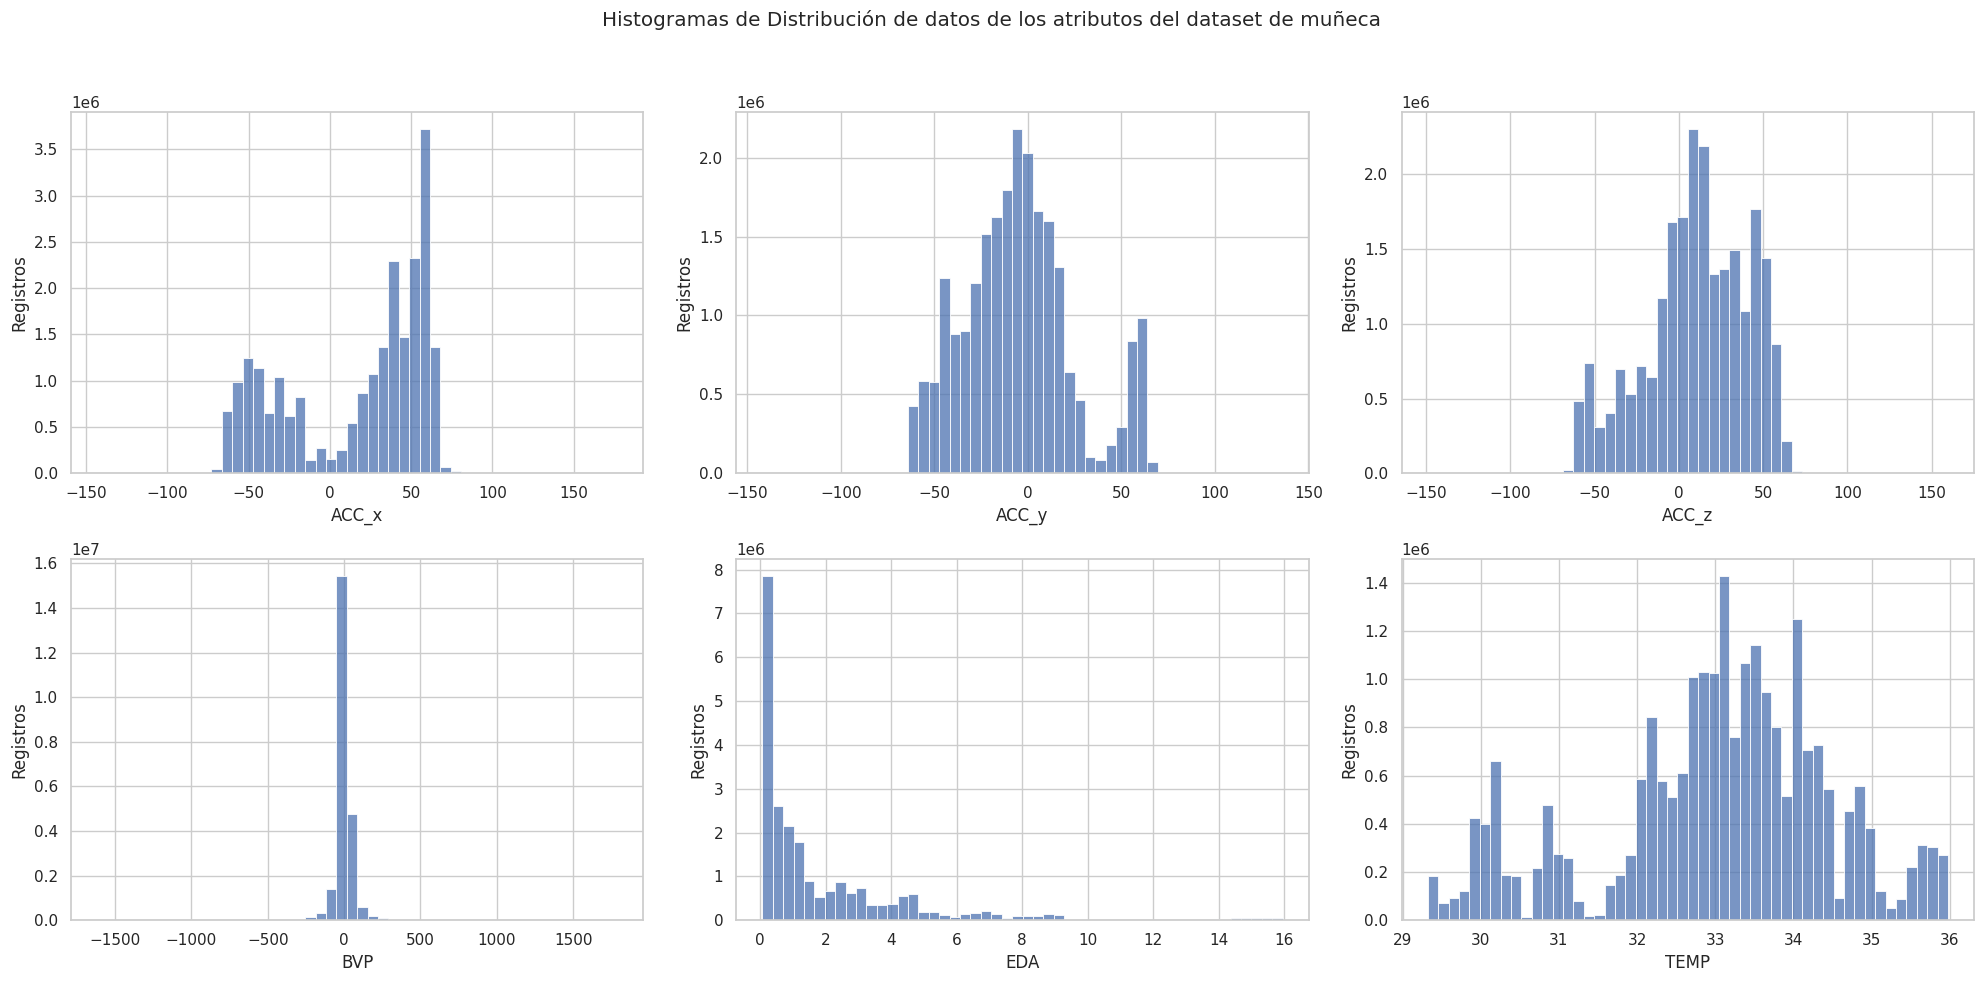

In [41]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle('Histogramas de Distribución de datos de los atributos del dataset de muñeca')

for i, column in enumerate(df_num.columns):
    sns.histplot(df_num[column], bins=50, kde=False, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_ylabel('Registros') 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

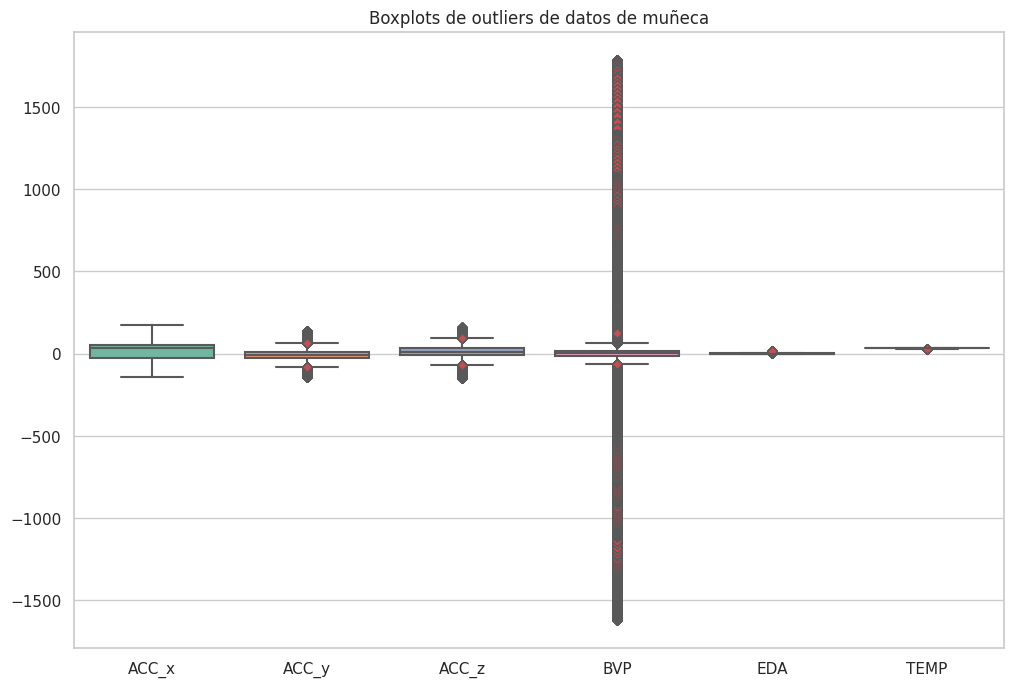

In [42]:
# comprobar outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_num, palette='Set2', orient='v', flierprops=dict(markerfacecolor='r', marker='D'))

plt.title('Boxplots de outliers de datos de muñeca')

plt.show()

In [44]:
z_scores = np.abs((df_num - df_num.mean()) / df_num.std())
threshold = 3 
outliers_count = (z_scores > threshold).sum()
print("Cantidad de outliers en cada columna:\n", outliers_count)

Cantidad de outliers en cada columna:
 ACC_x      1270
ACC_y      2707
ACC_z     11687
BVP      526356
EDA      464734
TEMP          0
dtype: int64


In [45]:
n_registers = df_wrist.count()[0]
percentage = 526356/n_registers
print(f'El mayor porcentaje de outliers en el conjunto de datos es {percentage * 100:.2f}%')

El mayor porcentaje de outliers en el conjunto de datos es 2.27%
